In [1]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
df = pd.read_csv('mpg.csv')
df = df.drop(['name'], axis=1)
df['weight-range_ord'] = pd.Categorical(df['weight-range']).codes
df['year-range_ord'] = pd.Categorical(df['year-range']).codes

q = df['weight'].quantile(0.99)

df.head()

,weight-range,year-range,model-year,mpg,weight,percent-weight-front,length,width,height,cylinders,eng-displacement,trans,trans-speed,weight-range_ord,year-range_ord
0,1500-2000,1988-1992,1988,47.0,1562.0,59.0,144.49,60.24,53.15,3,1.0,0,5,0,0
1,2000-2500,1988-1992,1989,39.0,1562.0,59.0,144.49,60.24,53.15,3,1.0,0,5,1,0
2,1500-2000,1993-1997,1993,40.0,1648.0,60.0,147.64,62.20,53.15,3,1.0,0,5,0,1
3,1500-2000,2009-2015,2012,35.0,1653.0,43.0,106.30,61.42,60.63,3,1.0,0,5,0,4
4,2000-2500,1988-1992,1989,40.0,1661.0,59.0,146.06,62.20,53.15,3,1.0,0,5,1,0


['weight', 'year-range_ord', 'cylinders', 'eng-displacement', 'trans', 'trans-speed']


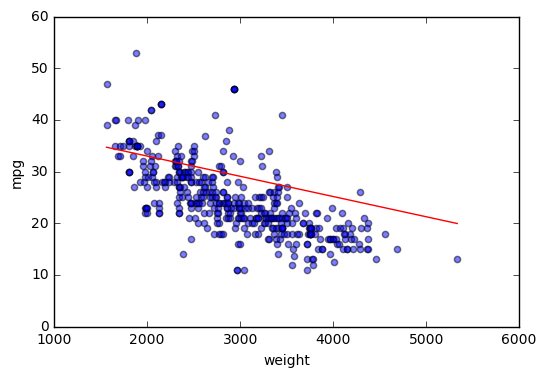

const               40.813827
weight              -0.003915
year-range_ord       0.648241
cylinders           -0.123206
eng-displacement    -2.624156
trans                0.630378
trans-speed          0.185127
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     105.0
Date:                Sun, 19 Nov 2017   Prob (F-statistic):           3.61e-80
Time:                        21:31:45   Log-Likelihood:                -1237.1
No. Observations:                 424   AIC:                             2488.
Df Residuals:                     417   BIC:                             2517.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               40.8138      1.767     23.097      0.000        37.340    44.287
weight              -0.0039      0.001     -7.541      0.000        -0.005    -0.003
year-range_ord       0.6482      0.173      3.743      0.000         0.308     0.989
cylinders           -0.1232      0.337     -0.366      0.714        -0.785     0.538
eng-displacement    -2.6242      0.560     -4.689      0.000        -3.724    -1.524
trans                0.6304      0.503      1.254      0.211        -0.358     1.619
trans-speed          0.1851      0.304      0.608      0.543        -0.413     0.783
==============================================================================
Omnibus:                      114.738   Durbin-Watson:                   1.299
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              357.859
Skew:                           1.238   Prob(JB):                     1.96e-78
Kurtosis:                       6.758   Cond. No.                     2.48e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [4]:
# keys = list(set([k for k in df.keys()]).difference(set([
#     'name', 'mpg'
# ])))
keys = [
    'weight',
#     'weight-range_ord',
    'year-range_ord',
#     'model-year',
#     'length',
#     'width', 
#     'height', 
    'cylinders',
    'eng-displacement', 
    'trans',
    'trans-speed',
]
print(keys)
X = df[keys]
y = df['mpg']
X = sm.add_constant(X)
est = sm.OLS(y, X.astype(float)).fit()
est.summary()

plt.scatter(df.weight, df.mpg, alpha=0.3)
plt.xlabel('weight'), plt.ylabel('mpg')
weight_linspace = np.linspace(df.weight.min(), df.weight.max(), 100)

est = sm.OLS(y, X).fit()
plt.plot(weight_linspace, est.params[0] + est.params[1] * weight_linspace, 'r')
plt.show(), plt.gcf().clear()
print(est.params)
est.summary()

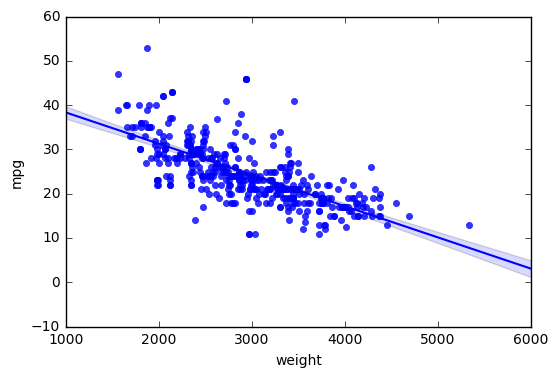

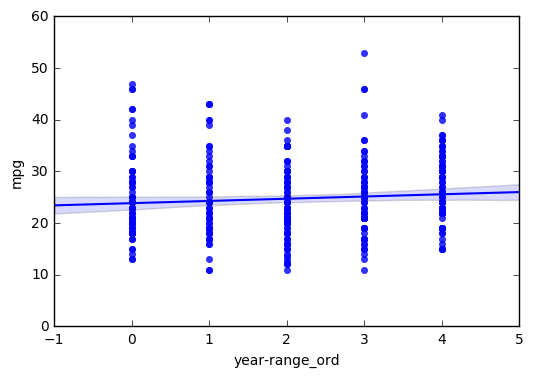

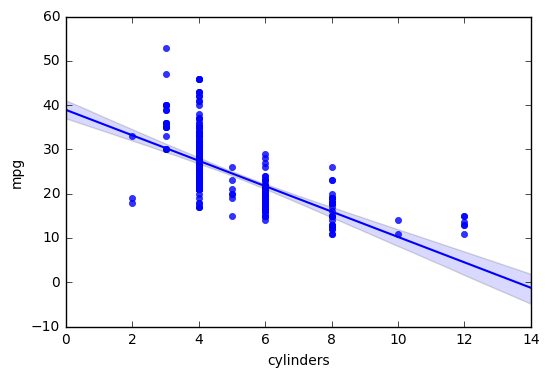

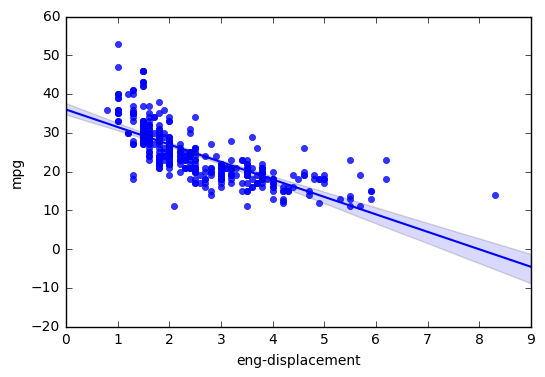

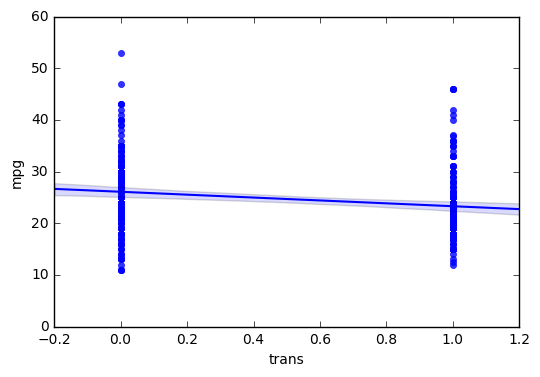

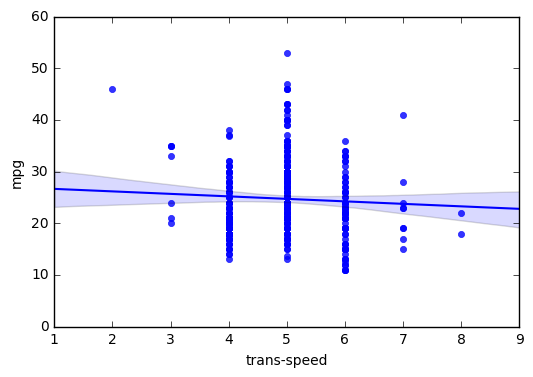

In [6]:
for k in keys:
    sb.regplot(x=k, y='mpg', data=df)
    plt.show(), plt.gcf().clear()